In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

In [15]:
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path+"\\code")

from dataexp_plots import cat_plot

In [26]:
data = pd.read_csv('../export_files/data.csv')

# make categorical variables object
obj_colnames = ['homeown', 'income', 'race', 'lif_cyc', 'urbrur', 'htppopdn']
for col in obj_colnames:
    data[col] = data[col].astype('object')

In [27]:
data.dtypes

houseid       int64
fuel          int64
vehmiles    float64
homeown      object
income       object
race         object
hhvehcnt      int64
hhsize        int64
numadlt       int64
drvrcnt       int64
wrkcount      int64
lif_cyc      object
urbrur       object
htppopdn     object
location     object
dtype: object

## Analysis scope

* California
* Sedan, crossover, and SUV - vehicle class that have electric power train and internal combustion enegine powertrain
* Vehicles of year 2011 or newer - when electric vehicle were started to be sold to early adopters
* Household level and household attributes - since the respondent is not necessarly the person who decides which vehicle to buy for the household

## Response Variable

__Powertrain types:__
* Electric Vehicle (EV)
* Internal Combustion Engine Vehicle (ICEV)

heavily unbalanced!

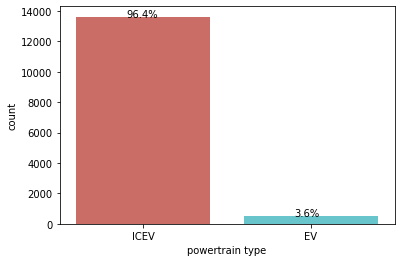

In [12]:
ax = sns.countplot(x='fuel', data=data, palette='hls')
ax.set(xticklabels=['ICEV','EV'])
plt.xlabel('powertrain type')
total = ax.patches[0].get_height() + ax.patches[1].get_height()
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()/total*100), (p.get_x()+0.3, p.get_height()+1))
plt.show(ax)

## Categorical Variables

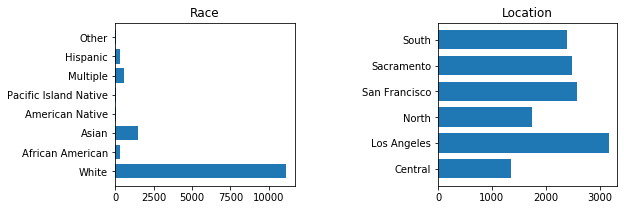

In [16]:
data_column = [data.race,data.location]
title = ['Race','Location']
yticklabels = [['White','African American','Asian','American Native','Pacific Island Native','Multiple','Hispanic','Other'],
              ['Central','Los Angeles','North','San Francisco','Sacramento','South','NA']]
cat_plot(data_column,title,yticklabels)

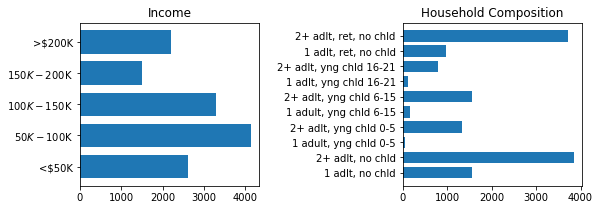

In [18]:
data_column = [data.income,data.lif_cyc]
title = ['Income','Household Composition']
yticklabels = [['<$50K','$50K-$100K','$100K-$150K','$150K-$200K','>$200K'],
              ['1 adlt, no chld','2+ adlt, no chld','1 adult, yng chld 0-5',
               '2+ adlt, yng chld 0-5','1 adult, yng chld 6-15','2+ adlt, yng chld 6-15',
               '1 adlt, yng chld 16-21','2+ adlt, yng chld 16-21','1 adlt, ret, no chld',
               '2+ adlt, ret, no chld']]
cat_plot(data_column,title,yticklabels)

__Race:__ does not represnt well CA population. won't affect the analysis of this project.

__Location:__ well equal distribution among CA zones.

__Income:__ well equal distribution among income levels.

__Family:__ most households with 2 adults. many households without children.

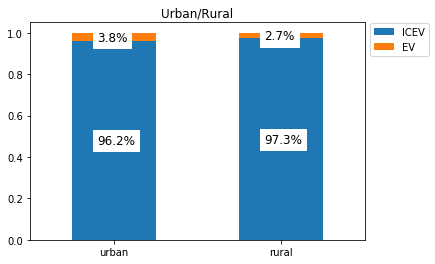

In [21]:
urb_serie = data.groupby('urbrur')['fuel'].value_counts().sort_index()[1]
rur_serie = data.groupby('urbrur')['fuel'].value_counts().sort_index()[2]
urb_serie = urb_serie*(100/urb_serie.sum())
rur_serie = rur_serie*(100/rur_serie.sum())
df_per = pd.DataFrame(np.array([list(urb_serie), list(rur_serie)]), index = [1, 2], columns = [0, 1])
values = [df_per.values[0][0],df_per.values[1][0],df_per.values[0][1],df_per.values[1][1]]

kx = -0.1
ky = -0.02

table = pd.crosstab(data.urbrur,data.fuel)
ax = table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

for i,rec in enumerate(ax.patches):
    ax.text(rec.get_xy()[0]+rec.get_width()/2+kx,rec.get_xy()[1]+rec.get_height()/2+ky,
            '{:.1%}'.format(values[i]/100), fontsize=12, color='black',backgroundcolor='white')
    
plt.title('Urban/Rural')
plt.xticks(np.arange(2), ['urban', 'rural'],rotation=360)
plt.legend(bbox_to_anchor=(1, 1.02),labels=['ICEV','EV'])
plt.xlabel('')
plt.show()

as expected, urban households are more likely to have electric vehicles. urban living characterized by shorter trips on better pavements.

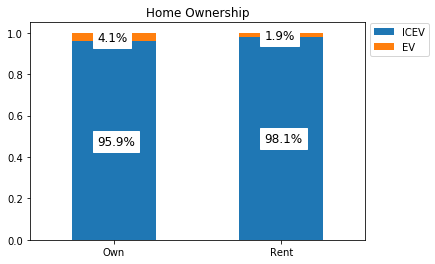

In [22]:
data_temp = data.copy()
data_temp.drop(data_temp[data_temp['homeown'] == 97].index, inplace=True)
own_serie = data_temp.groupby('homeown')['fuel'].value_counts().sort_index()[1]
ren_serie = data_temp.groupby('homeown')['fuel'].value_counts().sort_index()[2]
own_serie = own_serie*(100/own_serie.sum())
ren_serie = ren_serie*(100/ren_serie.sum())
df_per = pd.DataFrame(np.array([list(own_serie),list(ren_serie)]), index = [1,2], columns = [0,1])
values = [df_per.values[0][0],df_per.values[1][0],
          df_per.values[0][1],df_per.values[1][1]]

kx = -0.1
ky = -0.02

table=pd.crosstab(data_temp.homeown,data_temp.fuel)
ax = table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

for i,rec in enumerate(ax.patches):
    ax.text(rec.get_xy()[0]+rec.get_width()/2+kx,rec.get_xy()[1]+rec.get_height()/2+ky,
            '{:.1%}'.format(values[i]/100), fontsize=12, color='black',backgroundcolor='white')
    
plt.title('Home Ownership')
plt.xticks(np.arange(2), ['Own', 'Rent'],rotation=360)
plt.legend(bbox_to_anchor=(1, 1.02),labels=['ICEV','EV'])
plt.xlabel('')
plt.show()

as expected, home owners are more likely to have electric vehicle. the process of charger installation is easier for homeowners than renters.

## Numerical Variables

In [23]:
print(data.shape)
data.loc[:,data.columns.isin(['vehmiles','hhvehcnt','hhsize','numadlt','drvrcnt','wrkcount'])].describe().round(2)

(14146, 15)


,vehmiles,hhvehcnt,hhsize,numadlt,drvrcnt,wrkcount
count,8092.00,14146.00,14146.00,14146.00,14146.00,14146.00
mean,10981.75,2.40,2.45,2.05,1.99,1.27
std,7421.04,1.18,1.20,0.80,0.78,0.96
min,0.00,1.00,1.00,1.00,1.00,0.00
25%,6000.00,2.00,2.00,2.00,2.00,1.00
50%,10000.00,2.00,2.00,2.00,2.00,1.00
75%,14000.00,3.00,3.00,2.00,2.00,2.00
max,140000.00,12.00,11.00,8.00,7.00,6.00


__vehmiles:__ annual vehicle miles (miles driven in the past year). many missing values.

__hhvehcnt:__ number of vehicles in a household. from 1 to 12. reasonable average 2.40.

__hhsize:__ number of people in a household. from 1 to 11. reasonable average of 2.45.

__numadlt:__ number of adults (above 18) in a household. from 1 to 8. reasonable average of 2.05.

__drvrcnt:__ number of people with a driver license in a household. from 1 to 7. reasonable average of 1.99.

__wrkcount:__ number of employeed people in a household. from 0 to 6. reasonable average of 1.27